# Macaque Analysis Notebook

**Abhay Katoch**

*Sunday, December 15th, 2024*

### To-Do List:
- [ ] Implement multiple runs for tSNE output.

### Importing Libraries

In [1]:
import os
import random
random.seed(634)

from pathlib import Path
data_directory = Path("/Users/abhay/Documents/School/Thesis/project/data/macaque_data")

# libraries for dealing with numbers / data files
import numpy as np
import pandas as pd

# Libraries for plotting
from matplotlib import pyplot as plt

# Libraries for Stats
from statsmodels.stats.anova import AnovaRM
import scipy.stats as ss

# Custom code libraries for managing data
from functions.reduce_dimensions import smooth_columns, reduce_dim, calculate_jumps

### Loading fMRI Data

In [2]:
# Construct a list of directories, each of which contains all scans for a particular patient.
directories = sorted([directory for directory in os.listdir(data_directory) if not directory.startswith('.')])
conditions = ['1.00%','1.25%','1.50%','1.75%','2.00%','2.75%']

# Initialize a dictionary where each key are the directories mentioned above, and each value is the concatenated fMRI scans.
concatenated_scans = {directories[i]: np.zeros(shape = (1800, 174)) for i in range(len(directories))}

# For each directory, load every scan in the directory then concatenate the scans into the above-mentioned dictionary.
for directory in directories:
    scans = sorted([f for f in os.listdir(os.path.join(data_directory, directory)) if f.endswith('.csv')])

    scans_list = []
    for scan in scans:
        filepath = os.path.join(data_directory, directory, scan)
        data = np.loadtxt(filepath, delimiter = ",")
        scans_list.append(data)
    
    concatenated_scans[directory] = np.concatenate([scan for scan in scans_list], 0)

### Running tSNE and Plotting Results

In [3]:
# Initialize a dictionary where each key are the directories mentioned above, and each value is the tsne output.
tsne_output = {directories[i]: np.zeros(shape = (1800, 2)) for i in range(len(directories))}

for directory in directories:
    smoothed_data = smooth_columns(concatenated_scans[directory], 5)
    tsne_output[directory] = reduce_dim(smoothed_data)

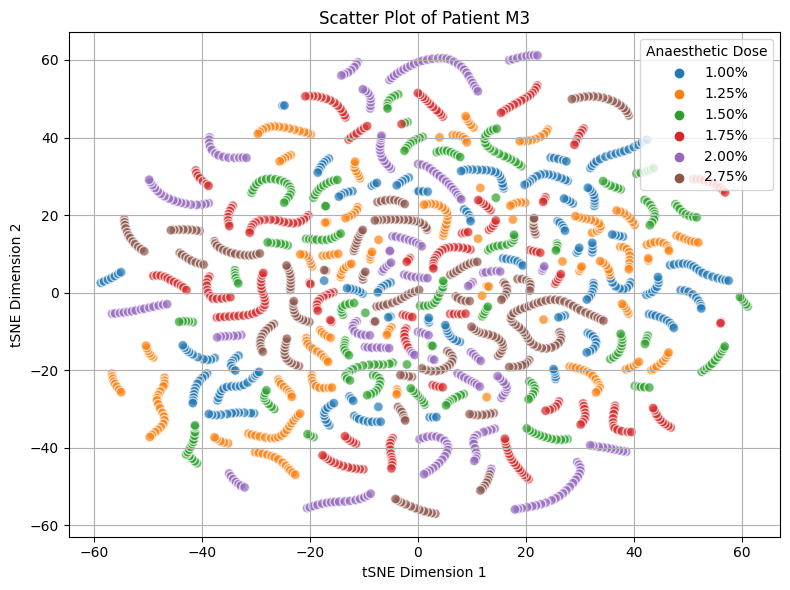

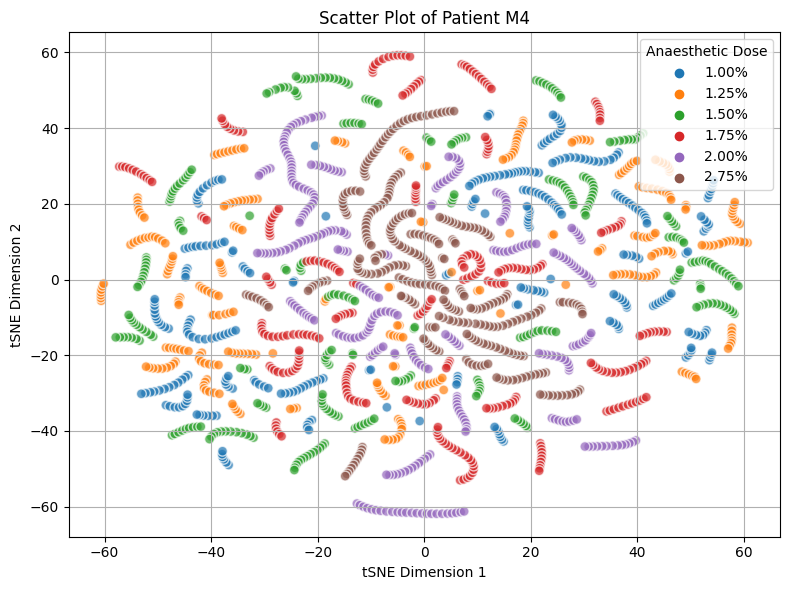

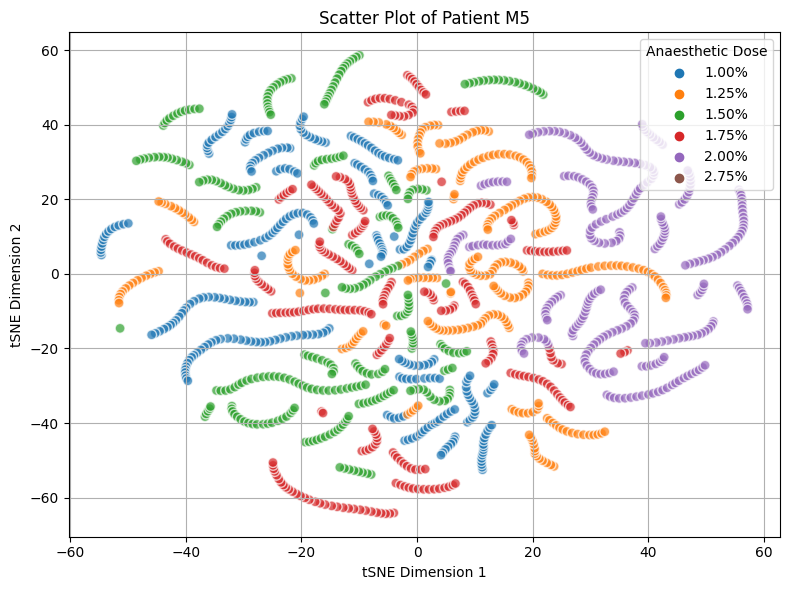

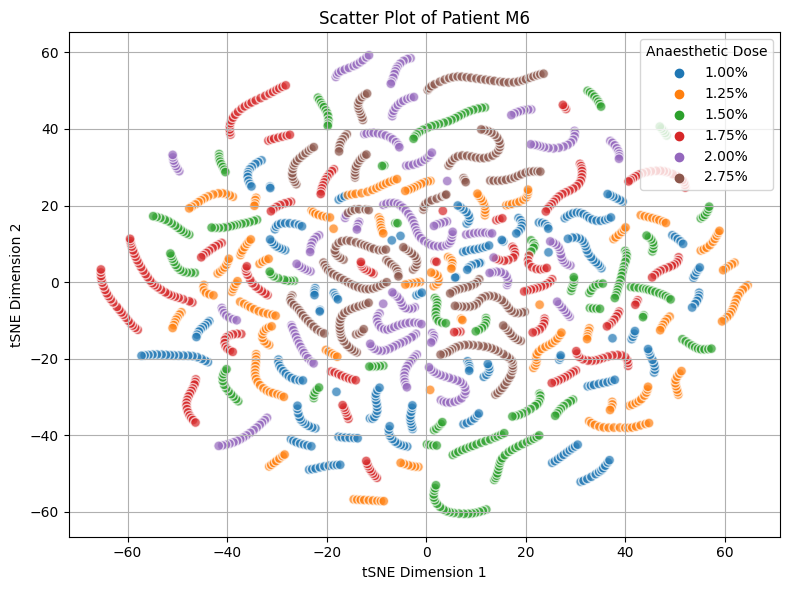

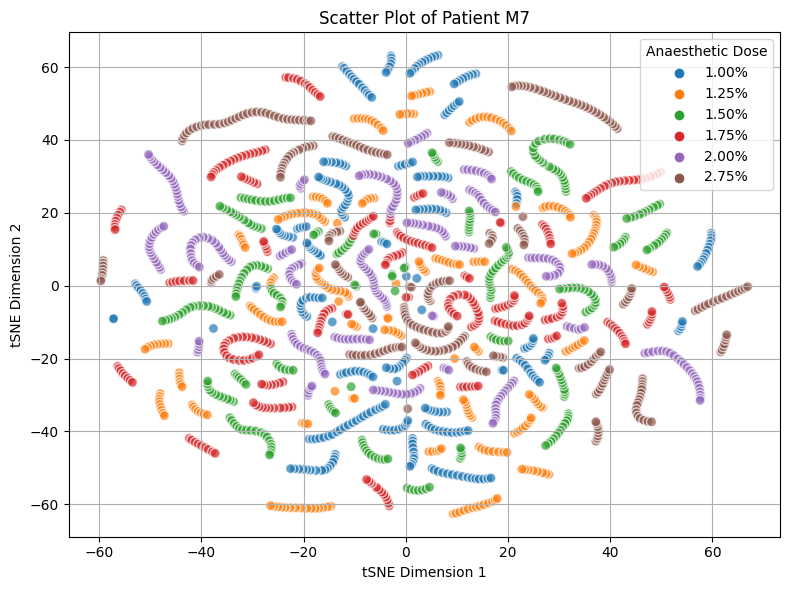

In [4]:
# For each patient, plot the concatenated tSNE output by anaesthetic dose. 
for directory in directories:
    x = tsne_output[directory][:, 0]
    y = tsne_output[directory][:, 1]
    
    plt.figure(figsize=(8, 6))
    # Create a colormap, where each timepoint is assigned an anaesthetic dose, from 1.00% to 2.75%.
    colors = plt.cm.tab10(np.repeat(np.arange(len(x) // 300), 300))
    scatter = plt.scatter(x, y, c = colors, alpha = 0.7, edgecolors = 'w', s = 50)

    # Add Legend
    # Note that patient M5 still shows a label for 2.75%, but doesn't have points labeled for it.
    for i, label in enumerate(conditions):
        plt.scatter([], [], color=plt.cm.tab10(i), label=label)

    plt.legend(loc='upper right', title="Anaesthetic Dose")
    plt.title(f"Scatter Plot of Patient {directory}")
    plt.xlabel('tSNE Dimension 1')
    plt.ylabel('tSNE Dimension 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Calculating Mentation Rate

In [5]:
full_patients = [patient for patient in tsne_output if tsne_output[patient].shape[0] == 1800]
mentation_rate = pd.DataFrame(columns = conditions, index = full_patients)

for patient in full_patients:
    split_data = np.array_split(tsne_output[patient], 12, axis=0)
    conditions_dataset = {conditions[i]: split_data[i] for i in range(len(conditions))}

    for condition in conditions_dataset:
        peaks, rate = calculate_jumps(conditions_dataset[condition], 2)
        mentation_rate.loc[patient, condition] = rate

mentation_rate

,1.00%,1.25%,1.50%,1.75%,2.00%,2.75%
M3,4.0,3.0,3.4,2.4,3.0,3.2
M4,3.4,3.0,2.8,3.2,2.4,3.2
M6,3.2,2.8,2.6,3.0,2.4,2.6
M7,2.6,2.8,3.6,2.4,2.6,2.2


### Running Repeated-Measures ANOVA and T-Test of Slopes

In [6]:
mentation_rate_long = mentation_rate.reset_index().melt(
    id_vars = ["index"],
    var_name = "Condition",
    value_name = "Rate"
)

anova = AnovaRM(mentation_rate_long, depvar="Rate", subject="index", within=["Condition"])
anova_results = anova.fit()

print(anova_results)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Condition  1.6389 5.0000 15.0000 0.2101



In [7]:
doses = np.array([1.00, 1.25, 1.50, 1.75, 2.00, 2.75])

slopes = []
intercepts = []
for patient in full_patients:
    mentation_rates = mentation_rate.loc[patient].values.astype('float')
    slope, intercept = np.polyfit(doses, mentation_rates, 1)

    slopes.append(slope)
    intercepts.append(intercept)

t_stat, p_value = ss.ttest_1samp(slopes, popmean = 0)
print(f"T-test to see if slope value differs from null hypothesis (m = 0): T = {t_stat}, p = {p_value}")

T-test to see if slope value differs from null hypothesis (m = 0): T = -4.62102351444933, p = 0.019076051815902623


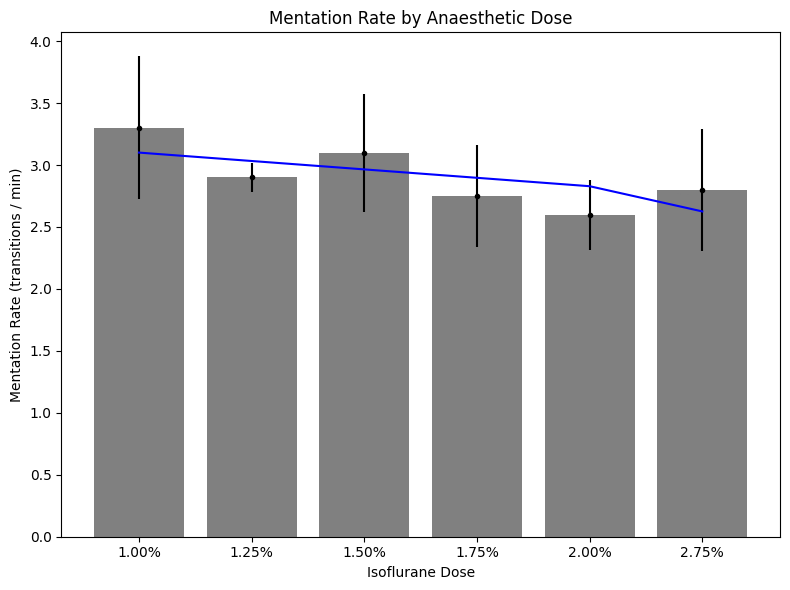

In [8]:
mean_rates = mentation_rate.mean(axis = 0).values
std_rates = mentation_rate.std(axis = 0).values
abline_values = [np.mean(slopes) * dose + np.mean(intercepts) for dose in doses]

plt.figure(figsize=(8, 6))
plt.bar(conditions, mean_rates, color = "grey")
plt.errorbar(conditions, mean_rates, std_rates, fmt='.', color='black')
plt.plot(conditions, abline_values, 'b')
plt.title(f"Mentation Rate by Anaesthetic Dose")
plt.xlabel('Isoflurane Dose')
plt.ylabel('Mentation Rate (transitions / min)')
plt.tight_layout()
plt.show()